In [1]:
using PyPlot
#plotly()
import StatsBase  

# Generating functions

In [2]:
function logphid(mu,d=1/2)
    return log(sum(mu.^d)^(1/d))
end

function logphid_c(mu,d=1/2)
    e=ones(length(mu))/length(mu)
    return logphid(mu,d)-logphid(e,d)
end

function posphid(mu,d=1/2)
    return mu.^(d)./(exp(d*logphid(mu,d)))
end

function psid(mu1,mu2,d=1/2)
    
    mu1=reshape(mu1,length(mu1),1)
    mu2=reshape(mu2,length(mu2),1)

    ret=mu2./mu1
    pos=posphid(mu1,d)
    
    rbh=log.(pos'*ret)[1,1]
    rrb=logphid(mu2,d)-logphid(mu1,d)
    
    return rbh-rrb,rrb
end


psid (generic function with 2 methods)

In [3]:
function logphie(mu)
    return mean(log.(mu))
end

function logphie_c(mu)
    e=ones(length(mu))/length(mu)
    return logphie(mu)-logphie(e)
end

function posphie(mu)
    e=ones(length(mu))/length(mu)
    return e
end

function psie(mu1,mu2)
    
    mu1=reshape(mu1,length(mu1),1)
    mu2=reshape(mu2,length(mu2),1)

    ret=mu2./mu1
    pos=posphie(mu1)
    
    rbh=log.(pos'*ret)[1,1]
    rrb=logphie(mu2)-logphie(mu1)
    
    return rbh-rrb,rrb
end



psie (generic function with 1 method)

In [4]:
function logphient(mu)
    mu=reshape(mu,length(mu),1)
    return -sum(mu'*log.(mu))
end

function logphient_c(mu)
    e=ones(length(mu))/length(mu)
    return logphient(mu)-logphient(e)
end


function posphient(mu)

    pos=(mu.*log.(mu))/sum(mu.*log.(mu))
    
    return pos
end

function psient(mu1,mu2)
    
    mu1=reshape(mu1,length(mu1),1)
    mu2=reshape(mu2,length(mu2),1)

    ret=mu2./mu1
    pos=posphient(mu1)
    
    rbh=log.(pos'*ret)[1,1]
    rrb=logphient(mu2)-logphient(mu1)
    
    return rbh-rrb,rrb
end


psient (generic function with 1 method)

In [5]:
function generatedata(f)
    
    n = 100
    x = linspace(0.001, 0.999, n)
    xgrid=x*ones(n,1)'
    ygrid=xgrid'

    z = Array{Float64}(n, n)

    for i in 1:n
        for j in 1:n
        
        
            vv=[x[i],x[j],1-x[i]-x[j]]
        
            if x[i]+x[j]<1
                z[i, j] = f(vv)
            
            
            else
                z[i, j] = NaN
            end
        
        
        end
    end
    
    return xgrid,ygrid,z 
    
end

generatedata (generic function with 1 method)

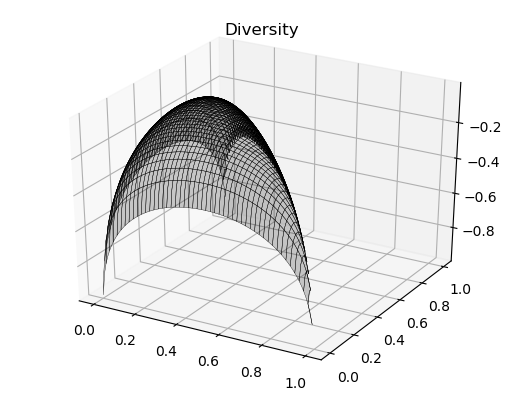

PyObject Text(0.5,0.92,'Diversity')

In [24]:
pygui(false)

xgrid,ygrid,z=generatedata(logphid_c)

surf(xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2,
cmap=ColorMap("gray"), alpha=0.2, linewidth=0.25)
title("Diversity")

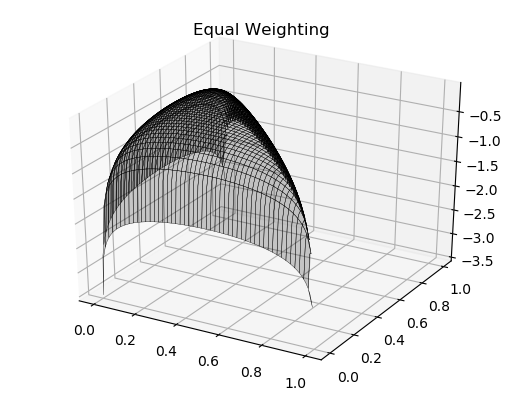

PyObject Text(0.5,0.92,'Equal Weighting')

In [7]:
pygui(false)

xgrid,ygrid,z=generatedata(logphie_c)

surf(xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2,
   cmap=ColorMap("gray"), alpha=0.2, linewidth=0.25)
title("Equal Weighting")


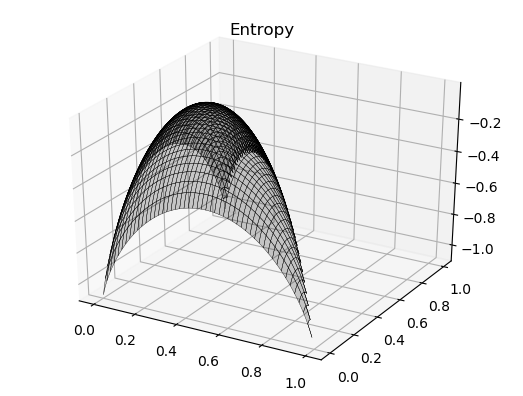

PyObject Text(0.5,0.92,'Entropy')

In [8]:

xgrid,ygrid,z=generatedata(logphient_c)

surf(xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2,
   cmap=ColorMap("gray"), alpha=0.2, linewidth=0.25)
title("Entropy")


# Simulations

In [9]:
function sim(t,nsim,mu,sig)
    
    srand(4972)
    na=length(mu)
    
    shocks=randn(t,na,nsim)
    ressim=Array{Float64, 3}(t,na,nsim)
    res=Array{Float64, 3}(t+1,na,nsim)
    
    
    dd=kron((mu-0.5*sig.^2)',ones(t,1))
    ss=kron(sig',ones(t,1))
    
    for k in 1:nsim
        
        ressim[:,:,k]=cumsum(ss.*shocks[:,:,k]+dd)
        res[:,:,k]=vcat(zeros(1,na),cumsum(ss.*shocks[:,:,k]+dd))
        
        
    end   

    
    return res
    
end

sim (generic function with 1 method)

In [10]:
function weights(data)
    
    res=Array{Float64, 3}(size(data))
    
    dataexp=exp.(data)
   
    for k in 1:size(data)[3]
        
        res[:,:,k]=dataexp[:,:,k]./(kron(ones(1,size(data)[2]),sum(dataexp[:,:,k],2)))
        
    end   
   
    return res
    
end

weights (generic function with 1 method)

## Parameters for the simulation


In [11]:
mu=[0.05 0.05 0.05]'
sig=[0.16 0.16 0.16]'
nsim=100000
T=100

print(mu-0.5*sig.^2)

res=sim(T,nsim,mu,sig);


[0.0372; 0.0372; 0.0372]

for k in 1:nsim

    fig = figure(k)
    plot(res[:,:,k])

end


In [12]:
ww=weights(res);

In [13]:
pygui(true)
fig = figure()

#for k in 1:size(ww)[3]
for k in 50:51
    
    tt=ww[:,:,k]
    rr=1:size(ww)[1]
    plot3D(tt[rr,1],tt[rr,2],tt[rr,3])
end

a11=linspace(0,1,100)
a12=1-a11
a13=0*a11


a22=linspace(0,1,100)
a23=1-a22
a21=0*a22

a33=linspace(0,1,100)
a31=1-a33
a32=0*a33


plot3D(a11,a12,a13,color = "k")
plot3D(a21,a22,a23,color = "k")
plot3D(a31,a32,a33,color = "k")
    
ax = gca()
ax[:set_xlim]([0,1])
ax[:set_ylim]([0,1])
ax[:set_zlim]([0,1])



(0, 1)

In [14]:
function return_attrib(ww,f)
 
    gamstar=Array{Float64, 2}(size(ww)[1]-1,size(ww)[3])
    deltaphi=Array{Float64, 2}(size(ww)[1]-1,size(ww)[3])
    retphi=Array{Float64, 2}(size(ww)[1]-1,size(ww)[3])


    for k in 1:size(ww)[3]
        for j in 2:size(ww)[1]

            mu1=ww[j-1,:,k]
            mu2=ww[j,:,k]

            #if k==1 && j==2 print(f(mu1,mu2)) end
            gamstar[j-1,k],deltaphi[j-1,k]=f(mu1,mu2)

            retphi[j-1,k]=gamstar[j-1,k]+deltaphi[j-1,k]
        end
    end

    return retphi,gamstar,deltaphi

end

return_attrib (generic function with 1 method)

In [15]:
retphi_d,gamstar_d,deltaphi_d=return_attrib(ww,psid);
retphi_e,gamstar_e,deltaphi_e=return_attrib(ww,psie);
retphi_ent,gamstar_ent,deltaphi_ent=return_attrib(ww,psient);



In [16]:
function cumulate(retphi,gamstar,deltaphi)

    retphi_cum=Array{Float64, 2}(size(retphi)[1],size(retphi)[2])
    gamstar_cum=Array{Float64, 2}(size(retphi)[1],size(retphi)[2])
    deltaphi_cum=Array{Float64, 2}(size(retphi)[1],size(retphi)[2])

    for k in 1:size(retphi)[2]

        retphi_cum[:,k]=cumsum(retphi[:,k])
        gamstar_cum[:,k]=cumsum(gamstar[:,k])
        deltaphi_cum[:,k]=cumsum(deltaphi[:,k])

    end
    
    return retphi_cum,gamstar_cum,deltaphi_cum

end

cumulate (generic function with 1 method)

In [17]:
retphi_d_cum,gamstar_d_cum,deltaphi_d_cum=cumulate(retphi_d,gamstar_d,deltaphi_d)
retphi_e_cum,gamstar_e_cum,deltaphi_e_cum=cumulate(retphi_e,gamstar_e,deltaphi_e)
retphi_ent_cum,gamstar_ent_cum,deltaphi_ent_cum=cumulate(retphi_ent,gamstar_ent,deltaphi_ent);

pygui(false)

for k in 1:5

    fig = figure(k)
    plot(retphi_cum[:,k])
    plot(gamstar_cum[:,k])
    plot(deltaphi_cum[:,k])

end

In [18]:
t=size(retphi_d_cum)[1]
print(mean(retphi_d_cum[t,:]/t))
print("\n")
print(mean(retphi_e_cum[t,:]/t))
print("\n")
print(mean(retphi_ent_cum[t,:]/t))

0.0012792863954211799
0.002016727505867696
0.0017633849875904708

In [19]:
print(mean(gamstar_d_cum[t,:]/t))
print("\n")
print(mean(gamstar_e_cum[t,:]/t))
print("\n")
print(mean(gamstar_ent_cum[t,:]/t))

0.003870940660529318
0.008496636506431789
0.0057760101897069765

In [20]:
print(mean(deltaphi_d_cum[t,:]/t))
print("\n")
print(mean(deltaphi_e_cum[t,:]/t))
print("\n")
print(mean(deltaphi_ent_cum[t,:]/t))

-0.0025916542651081374
-0.006479909000564091
-0.0040126252021165055

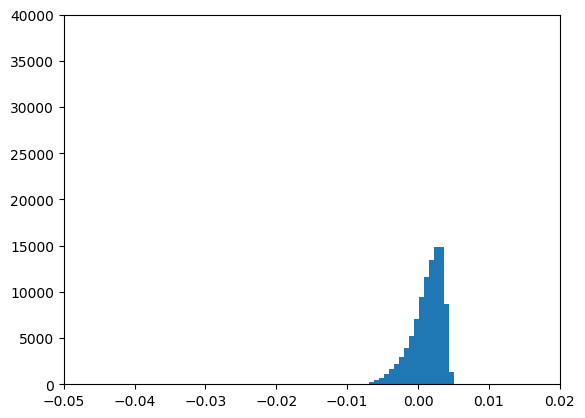

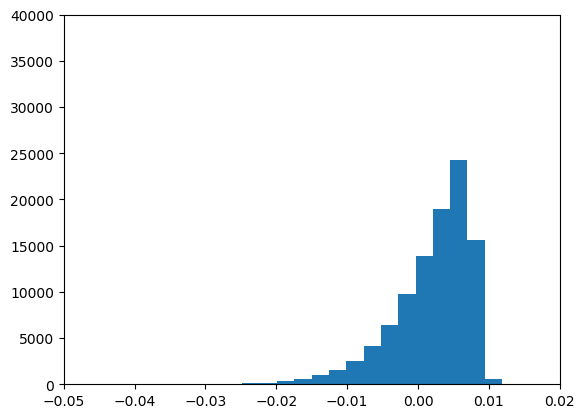

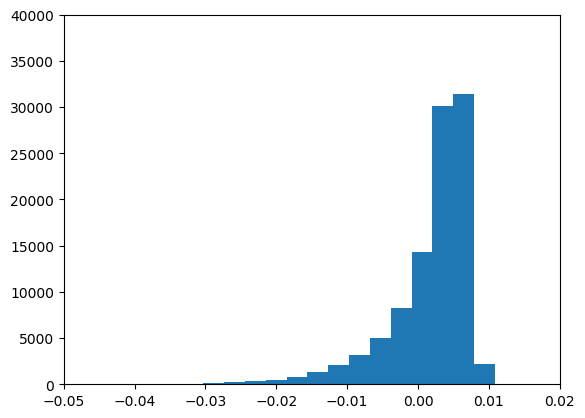

(0, 40000)

In [21]:
pygui(false)
figure(1)
h = PyPlot.plt[:hist](retphi_d_cum[t,:]/t,20);
ax = gca()
ax[:set_xlim]([-0.05,0.02])
ax[:set_ylim]([0,40000])

figure(2)
h = PyPlot.plt[:hist](retphi_e_cum[t,:]/t,20);
ax = gca()
ax[:set_xlim]([-0.05,0.02])
ax[:set_ylim]([0,40000])

figure(3)
h = PyPlot.plt[:hist](retphi_ent_cum[t,:]/t,20);
ax = gca()
ax[:set_xlim]([-0.05,0.02])
ax[:set_ylim]([0,40000])


In [22]:
cdf_d=StatsBase.ecdf(retphi_d_cum[t,:]/t)
cdf_e=StatsBase.ecdf(retphi_e_cum[t,:]/t)
cdf_ent=StatsBase.ecdf(retphi_ent_cum[t,:]/t)

(::ef) (generic function with 2 methods)

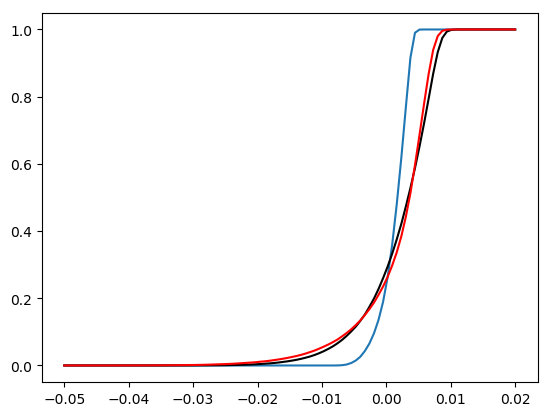

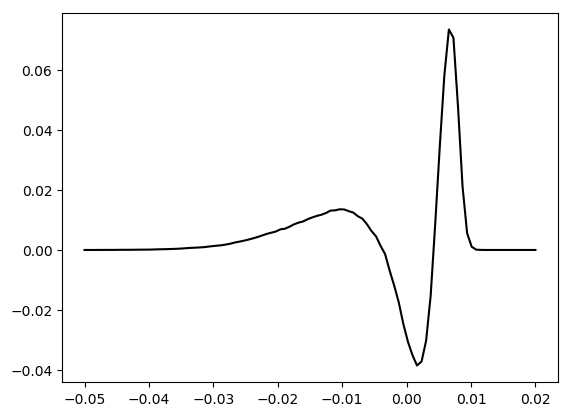

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13d42ab10>

In [23]:
x=linspace(-0.05,0.02,100)

fig=figure(1)
plot(x,cdf_d(x))
plot(x,cdf_e(x),color="k")
plot(x,cdf_ent(x),color="r")
fig=figure(2)
plot(x,cdf_ent(x)-cdf_e(x),color="k")
